# Desenvolvimento do DBSCAN <h1>

Primeiro projeto da disciplina MC886 2021.1

Desenvolvido por Felipe Arruda (RA: 196862) e Leonardo Koike (RA: 201332)

In [1]:
#imports das bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
from mpl_toolkits import mplot3d

# Leitura e tratamento 
dos dados disponibilizados pelo trabalho para a utilização pelo algorítmo. 

In [2]:
# Dados carregados em um numpy array
data = np.loadtxt('cluster.dat')

In [3]:
# Dados normalizados que serão utilizados como uma comparação 
data_norm = data/data.max(axis=0)

In [4]:
# divisão para dados de treinamento e dados de teste
np.random.shuffle(data_norm)
train_index_norm = int(data_norm.shape[0]*0.9)
train_data_norm,test_data_norm = np.vsplit(data_norm,[train_index_norm])

# Algorítmo 

## Para realizar o treino do modelo, utilizamos a função *dbscan*
Utilizamos neste notebook o DBSCAN como apresentado em sala de aula.

A função recebe o dado para treinamento do modelo e os parâmetros para o algoritmo do DBSCAN (número de vizinhos e raio da vizinhança)

O retorno da função consiste de: 
* todos os core points das vizinhanças
* todos os border poitns de uma dada vizinhança
* todos os outliers do conjunto de dados
* um inteiro representando o número de cluster(ou vizinhanças)

O algoritmo passa por todos os pontos disponíveis do dataset com o auxilio de duas listas: availabe_points e index_points. A primeira reflete todos os pontos que ainda não foram localizados pelo algoritmo, já a segunda são pontos que o algoritmo já conseguiu localizar, mas ainda não foram classificados.

A lógica do DBSCAN segue o seguinte fluxo:
~~~
Enquanto TRUE

    se existem pontos dentro de index_points

        retiro o próximo ponto a ser avaliado de index_points

    se não

        aqui existe a lógica que trata da validação do cluster e dos outliers, bem como a 
          criação um novo cluster dentro do dicionário com os pontos avaliados como core_points e border_points. Essas 2 listas são limpas para mais uma rodada.

        se ainda existem availabe_points

            retiro o próximo ponto a ser avaliado de availabe_points

        se não

            o código realiza um break, já que todos os pontos do dataset foram avaliados

    com o ponto a ser avaliado como point, ele é retirado de availabe_points

    calculamos a distância euclidiana de point para todos os outros pontos do dataset

    são classificados como neighbors todos os pontos que tem um raio menor que radius_of_neighborhood do ponto avaliado

    core_neighbor_flag é uma flag para auxiliar na classificação de border_points

    Para todo neighbor de point
        se este neighbor não foi localizado ainda (não está em index_points) e nem avaliado (está em availabe_points)
            ele é adicionado à index_points
        se algum dos neighbors é core, a flag é classificada como 1
    
    agora para a classificação:
    se o número de neighbors é maior que number_of_neighbors, point é classificado como core
    se não
        se a core_neighbor_flag é 1, ou seja, existe um core point na vizinhança de point, ele é classificado como border
        se não ele é um outlier
~~~

## Para realizar o teste do modelo com o conjunto de dados de teste, existe a função *dbscan_fit*

Nesta função recebemos como parâmetros o conjunto de dados de teste, que são os pontos a serem avaliados, os core_points do modelo treinado e o raio da vizinhança a ser considerado.

Nele fazemos a busca por todos os clusters aos quais os core_points representam, a fim de testar se a distância dos pontos a serem avaliados do conjunto de teste está dentro do raio da vizinhança definido. Se existe algum vizinho dentro do raio, este ponto é classificado no mesmo cluster deste vizinho.

Depois de avaliar todos os core_points, se ainda houver availabe_points estes são classificados como outliers do teste.

A função retorna um dicionário com o mapeamento dos pontos de teste aos mesmos clusters do teste e uma lista com todos os outliers do teste 

In [5]:
def dbscan(data_in: np.ndarray, radius_of_neighborhood: float, number_of_neighbors: int):
    #inicialização da lista de classificação dos pontos
    core_points = []
    border_points = []
    outliers_points = []

    #cluster ajudará na cassificação dos cores junto aos clusters, os dois dicionários serão retornados
    cluster = 0
    cluster_cores = {}
    cluster_borders = {}

    #mepamento de todos os pontos do dataset, mantem a lista de quais não foram visitados ainda
    availabe_points = []
    for i in range(data_in.shape[0]):
        availabe_points.append(i)
    
    #escolha aleatoria de um ponto
    index_list = [np.random.choice(data_in.shape[0])]
    
    #enquanto ainda houver pontos não visitados, este laço é executado
    while True:
        
        #se existe elemento em index_list, ele retira o topo e continua o processamento
        #se não ele escolhe um aleatório dos pontos disponíveis
        if index_list:
            point = index_list.pop(0)
        else:
            if core_points:
                #etapa para verificar se outliers realmente são outliers levando em consideração os dicionários de corepoints formados
                for i in outliers_points:
                    
                    #calcula a distância entre o ponto escolhido e todos os outros do dataset
                    dist = np.linalg.norm(data_in[i]-data_in[core_points],axis=1)

                    neighbors = np.where(dist <= radius_of_neighborhood)[0]

                    core_neighbor_flag = 0
                    for j in neighbors:
                        if not core_neighbor_flag and j in core_points:
                            core_neighbor_flag = 1

                    #se algum dos vizinhos deste "outlier" em questão for core, ele é reclassificado como border
                    if core_neighbor_flag:
                        border_points.append(i)
                        outliers_points.remove(i)

                # Podemos montar os dicionários dos clusters, classificando como um novo cluster, iterando a variável cluster, 
                # já que chegamos em todos os pontos alcançáveis de acordo com os parâmetros passados para a função
            
                cluster_cores[cluster] = np.array(core_points)
                cluster_borders[cluster] = np.array(border_points)
                cluster += 1

                #limpeza das listas já classificadas em um cluster
                core_points.clear()
                border_points.clear()

            #se ainda existem pontos disponíveis
            if availabe_points:
                #escolha de um ponto aleatório dentro dos pontos disponíveis
                point = availabe_points[np.random.choice(len(availabe_points))]
            else:
                #saia do loop se acabarem os pontos disponíveis
                break
        
        #remove o ponto utilizado da lista de pontos disponíveis
        availabe_points.remove(point)
        
        #calcula a distância entre o ponto escolhido e todos os outros do dataset
        dist = np.linalg.norm(data_in[point]-data_in,axis=1)

        #identifica os vizinhos do ponto escolhido de acordo com o raio passado como parâmetro
        neighbors = np.where(dist <= radius_of_neighborhood)[0]
        
        #adiciona todos os pontos alcancáveis pelo ponto escolhido se ele ainda não foi processado e se ele já não está presente em index_list
        # identifica se algum dos vizinhos é um core point, vai ser importante para a classificação como border.
        core_neighbor_flag = 0
        for i in neighbors:
            if (i in availabe_points) and (i not in index_list):
                index_list.append(i)
            if not core_neighbor_flag and i in core_points:
                core_neighbor_flag = 1

        #classificação dos pontos
        if neighbors.shape[0] >= number_of_neighbors:
            core_points.append(point)
        elif core_neighbor_flag:
            border_points.append(point)
        else:
            outliers_points.append(point)

    return cluster_cores, cluster_borders, outliers_points, cluster


def dbscan_fit(test_data: np.ndarray, core_dict: dict, radius_of_neighborhood: float, train_data: np.ndarray):
    #os pontos serão divididos entre dicionários que representarão os clustes aos quais eles estão mapeados
    test_clusters = {}
    #retorno de todos os outliers encontrados no conjunto de teste
    outliers_found = []

    #lista para auxiliar controle de pontos que já foram avaliados.
    availabe_points = []
    for i in range(test_data.shape[0]):
        availabe_points.append(i)

    for cluster,cores in core_dict.items():
        #inicializa a lista que irá identificar os cluster do conjunto de testes
        test_clusters[cluster] = []

        for index in range(test_data.shape[0]):
            #para todo o ponto, é realizado um teste para saber se existe algum core_point do cluster em questão 
            #    na vizinhaça do ponto testado
            dist = np.linalg.norm(train_data[cores]-test_data[index],axis=1)
            if (dist <= radius_of_neighborhood).any():
                #se existe algum core na vizinhança do ponto avaliado ele é retirado de availabe_points e classificado no cluster
                test_clusters[cluster].append(index)
                availabe_points.remove(index)

    # para todo ponto que não foi classificado dentro de algum cluster é identificado como outlier
    while availabe_points:
        outliers_found.append(availabe_points.pop())


    return test_clusters, outliers_found

## Definição de hiperparâmetros para o raio da vizinhaça e número de vizinhos para o treino e teste dos dados

In [6]:
radius = 0.058 
nb_of_neighbors = 7

# Treino do modelo

In [7]:
core_train, border_train, outlier_train, n_clusters = dbscan(data_in = train_data_norm, radius_of_neighborhood = radius, number_of_neighbors = nb_of_neighbors) 

In [8]:
colors = cm.rainbow(np.linspace(0,1,n_clusters))

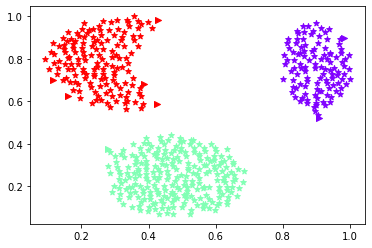

In [9]:
figure, axes = plt.subplots()
for value,color in zip(core_train.values(),colors):
    if value.size:
        x_core, y_core = np.hsplit(train_data_norm[value], 2)
        plt.scatter(x_core,y_core,marker='*',color=color)
for value,color in zip(border_train.values(),colors):
    if value.size:
        x_border, y_border = np.hsplit(train_data_norm[value], 2)
        plt.scatter(x_border,y_border,marker='>',color=color)
x_outlier, y_outlier = np.hsplit(train_data_norm[outlier_train], 2)
plt.scatter(x_outlier,y_outlier,marker='x',color=color)
draw_circle = []
j = 0
for i in range(x_outlier.shape[0]):
    draw_circle.append(plt.Circle((x_outlier[i,0], y_outlier[i,0]), radius, fill=False))
    axes.add_artist(draw_circle[j])
    j += 1
plt.show()

# Teste do modelo

In [10]:
test_result, test_outlier = dbscan_fit(test_data=test_data_norm, core_dict=core_train, radius_of_neighborhood=radius, train_data = train_data_norm)

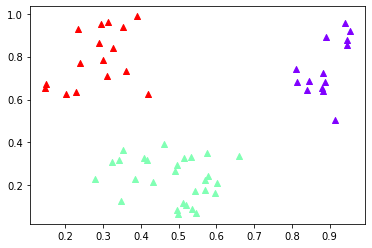

In [11]:
for value,color in zip(test_result.values(),colors):
    x_train, y_train = np.hsplit(test_data_norm[value], 2)
    plt.scatter(x_train,y_train,marker='^',color=color)
x_outlier_test, y_outlier_test = np.hsplit(test_data_norm[test_outlier], 2)
plt.scatter(x_outlier_test,y_outlier_test,marker='x',color='g')

# Junção do teste com o treino para plot e comparação:
* bolinhas são core points do treino
* estrelas são border points do treino
* Triangulos são os pontos pertencentes ao cluster de mesma cor
* se existir um X vermelho ou verde são pontos outliers do treino e do teste, respectivamente

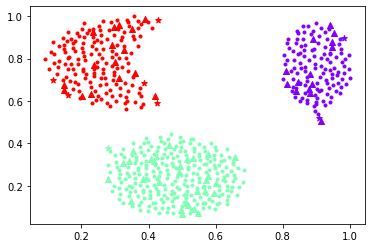

In [12]:
for value,color in zip(core_train.values(),colors):
    x_core, y_core = np.hsplit(train_data_norm[value], 2)
    plt.scatter(x_core,y_core,marker='.',color=color)
for value,color in zip(border_train.values(),colors):
    if value.size:
        x_border, y_border = np.hsplit(train_data_norm[value], 2)
        plt.scatter(x_border,y_border,marker='*',color=color)
for value,color in zip(test_result.values(),colors):
    x_test, y_test = np.hsplit(test_data_norm[value], 2)
    plt.scatter(x_test,y_test,marker='^',color=color)
x_outlier_train, y_outlier_train = np.hsplit(train_data_norm[outlier_train], 2)
x_outlier_test, y_outlier_test = np.hsplit(test_data_norm[test_outlier], 2)

plt.scatter(x_outlier_train,y_outlier_train,marker='x',color='r')
plt.scatter(x_outlier_test,y_outlier_test,marker='x',color='g')
plt.show()

## Até aqui a avaliação dos hiperparâmetros para o modelo foi feita no olhômetro, com testes e retreinos. Dessa forma, gostaríamos de avaliar automaticamente a qualidade dos modelos por métricas:

In [13]:
# Agregando os borders e cores do mesmo cluster
clusters = {}
for cluster,cores in core_train.items():
    clusters[cluster] = np.append(cores, border_train[cluster])

In [14]:
# preparando um array com a coluna a ser classificada com os lables dos clusters
df_silhouette = pd.DataFrame(train_data_norm)
df_silhouette['labels'] = 0
silhouette_labels = df_silhouette.values 

In [15]:
#classificação do df colocando as lables relativas aos clusters
for cluster, index in clusters.items():
    silhouette_labels[index, 2] = cluster
df_silhouette = pd.DataFrame(silhouette_labels,columns = ['x', 'y','labels'])

In [17]:
# Métricas para o gráfico de silhueta. silhouette_avg e sample_silhouette_values serão utilizados para plot do gráfico
silhouette_avg = metrics.silhouette_score(df_silhouette.values[:, :2], df_silhouette.values[:, 2])
df_silhouette['silhouette_samples'] = metrics.silhouette_samples(df_silhouette.values[:, :2], df_silhouette.values[:, 2])
sample_silhouette_values = df_silhouette['silhouette_samples'].values

In [18]:
# quanto mais próximo de 1 melhor é esta métrica
silhouette_avg

0.6966692058571444

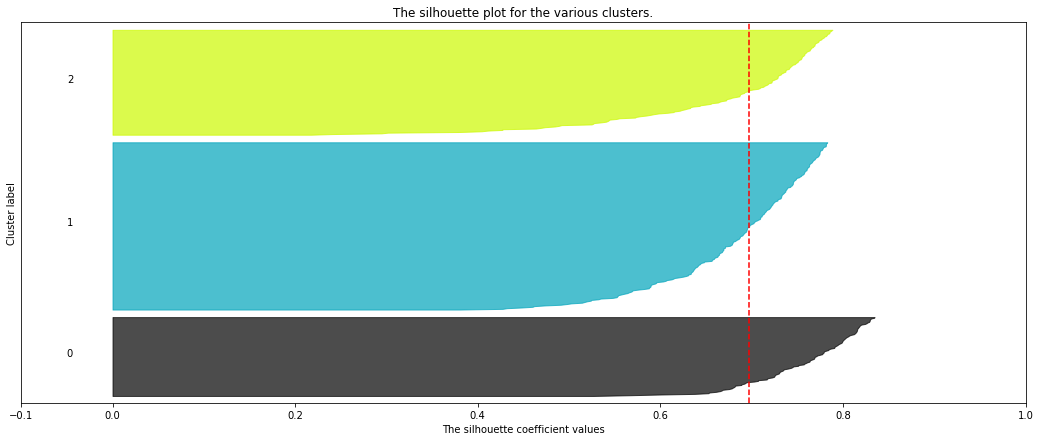

In [24]:
#codigo adaptado de https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

# The  plot of the silhouette 
# The silhouette coefficient can range from -1, 1 but in this example all
# values are > 0
ax1.set_xlim([-0.1, 1])

# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(sample_silhouette_values) + (n_clusters + 1) * 10])


cluster_labels = df_silhouette['labels']

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

# Discussão e comparação dos modelos